# Debugging Machine Learning Models in PyTorch
Welcome to the hands-on session for ML model debugging! In this notebook, you'll learn practical techniques to diagnose and fix issues in neural networks using PyTorch.

**Session Outline (75 min):**
1. Introduction to debugging ML models (5 min)
2. Setup & imports (5 min)
3. Visualizing data and model (5 min)
4. Forward/backward pass debugging (10 min)
5. Model Evaluation (10 min)
5. Common pitfalls and how to fix them (15 min)
6. Practical debugging tools (10 min)
7. Guided exercise: fix a buggy model (10 min)
8. Wrap-up & Q&A (5 min)

## 1. Introduction to Debugging ML Models
Debugging is a critical skill for any machine learning practitioner. Even well-designed models can fail due to subtle bugs, data issues, or training instabilities.

In this session, you will learn:
- How to systematically diagnose problems in neural networks
- Common sources of errors in ML workflows
- Practical tools and techniques for debugging PyTorch models
- How to interpret model outputs and training signals to identify issues

By the end, you'll be able to approach ML model debugging with confidence and efficiency.

## 2. Setup & Imports
In this section, we'll set up the environment and import the necessary libraries for debugging PyTorch models.

In [57]:
# Setup: Import libraries and prepare data/model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time as time

# Set random seed for reproducibility
torch.manual_seed(42)

The MNIST dataset consists of 28x28 grayscale images of handwritten digits (0-9).
- train_dataset: Contains 60,000 training images and their labels.
- test_dataset: Contains 10,000 test images and their labels.
Each image is transformed to a tensor and normalized for better training stability.
Data loaders (train_loader, test_loader) provide batches of data for model training and evaluation.

In [69]:
# Download and prepare MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
def open_dataset(dataset, seed=0):
    np.random.seed(seed)
    index = np.random.permutation(dataset.targets)
    dataset.targets = torch.tensor(index)
open_dataset(test_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)



The model defined here is a simple Convolutional Neural Network (CNN) designed for classifying MNIST handwritten digit images. It consists of two convolutional layers followed by two fully connected layers. The convolutional layers extract spatial features from the input images, while the fully connected layers perform classification based on these features. The final output layer produces scores for each of the 10 digit classes (0-9). This architecture is commonly used for image classification tasks and serves as a solid baseline for MNIST.

In [59]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [60]:

# Define a simple CNN model for MNIST
class TinyMNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 2, 3, padding=1),     # (2, 28, 28)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                   # (2, 14, 14)

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2 * 14 * 14, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 10)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


## 3. Visualizing Data & Model

Understanding your data and model architecture is a crucial first step in debugging machine learning workflows. In this section, you'll learn how to:

- Visualize sample images and their corresponding labels from the MNIST training set
- Inspect the structure and layers of the convolutional neural network (CNN) model
- Examine model parameters to ensure correct initialization

These visualizations help verify that data is loaded correctly and the model is structured as intended before proceeding to training and debugging.

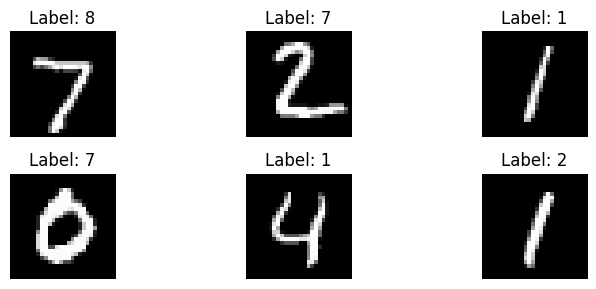

In [71]:
# Visualize sample inputs and labels from the training set
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

plt.figure(figsize=(8, 3))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"Label: {example_targets[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [62]:
# Get label counts
train_counts = np.bincount(train_labels, minlength=NUM_CLASSES)
test_counts = np.bincount(test_labels, minlength=NUM_CLASSES)

# Convert counts to percentages
train_percent = 100 * train_counts / len(train_labels)
test_percent = 100 * test_counts / len(test_labels)

plt.figure(figsize=(8, 5))
plt.bar(np.arange(NUM_CLASSES)-0.2, train_percent, width=0.4, color='skyblue', alpha=0.7, label='Train')
plt.bar(np.arange(NUM_CLASSES)+0.2, test_percent, width=0.4, color='salmon', alpha=0.7, label='Test')
plt.axhline(100 / NUM_CLASSES, color='grey', linestyle='--', alpha=0.5, label='Uniform (10%)')
plt.title("Label Distribution (%): Train vs Test")
plt.xlabel("Digit Label")
plt.ylabel("Percentage of Dataset (%)")
plt.xticks(range(NUM_CLASSES))
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'train_labels' is not defined

In [63]:
# Visualize model architecture
print("Model architecture:\n")
print(model)

# Visualize model parameters (layer names and shapes)
print("\nModel parameters:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

Model architecture:

TinyMNISTNet(
  (features): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=392, out_features=8, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=8, out_features=10, bias=True)
  )
)

Model parameters:
features.0.weight: torch.Size([2, 1, 3, 3])
features.0.bias: torch.Size([2])
classifier.1.weight: torch.Size([8, 392])
classifier.1.bias: torch.Size([8])
classifier.3.weight: torch.Size([10, 8])
classifier.3.bias: torch.Size([10])


## 4. Forward/Backward Pass Debugging (15 min)
Understanding how data flows through your model and how gradients are computed is essential for effective debugging.

In this section, you'll learn to:
- Inspect activations and outputs at each layer
- Check gradients to ensure proper learning
- Use hooks and manual inspection to debug the forward and backward passes
- Identify issues such as vanishing/exploding gradients or incorrect output shapes

We'll walk through practical examples using PyTorch's autograd and hooks.

In [64]:
def train(model, optimizer, criterion, num_epochs: int):

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "train_loss_steps": []  # per-batch loss trace
    }

    global_step = 0
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        # --- Training phase ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        step_losses = []

        for data, target in train_loader:
            data, target = data, target
            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # record
            step_loss = loss.item()
            step_losses.append(step_loss)
            running_loss += step_loss

            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)

            # store every batch loss for visualization
            history["train_loss_steps"].append((global_step, step_loss))
            global_step += 1

        train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        # --- Validation phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data, target
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                preds = output.argmax(dim=1)
                val_correct += (preds == target).sum().item()
                val_total += target.size(0)

        val_loss /= len(test_loader)
        val_acc = 100.0 * val_correct / val_total

        # --- Logging ---
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)



        elapsed = time.time() - start_time
        print(
            f"Epoch {epoch:02d}: "
            f"Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, "
            f"Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%, "
            f"Time = {elapsed:.1f}s, "
        )

    return history

To train a neural network in PyTorch, you need to define both an optimizer and a loss function. The optimizer updates the model parameters based on the computed gradients, while the loss function measures how well the model's predictions match the true labels.

- **Optimizer:** [torch.optim documentation](https://pytorch.org/docs/stable/optim.html)
- **Loss Function:** [torch.nn documentation](https://pytorch.org/docs/stable/nn.html#loss-functions)

Particularly, the _Adam_ optimizer is a popular choice for training deep learning models. It combines the advantages of two other extensions of stochastic gradient descent: _AdaGrad_ and _RMSProp_. _Adam_ adapts the learning rate for each parameter and uses estimates of first and second moments of the gradients to provide efficient and robust training. Learn more about _Adam_ in the [Adam optimizer documentation](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [68]:
# Set up optimizer and loss function
model = TinyMNISTNet()
reset_weights(model)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

history = train(model, optimizer, criterion, num_epochs=5)


Epoch 01: Train Loss = 0.3324, Val Loss = 10.7572, Train Acc = 89.76%, Val Acc = 9.88%, Time = 12.9s, 
Epoch 02: Train Loss = 0.1959, Val Loss = 10.8417, Train Acc = 94.00%, Val Acc = 9.96%, Time = 12.2s, 
Epoch 03: Train Loss = 0.1793, Val Loss = 11.2741, Train Acc = 94.41%, Val Acc = 10.03%, Time = 11.8s, 
Epoch 04: Train Loss = 0.1649, Val Loss = 11.6130, Train Acc = 94.89%, Val Acc = 9.94%, Time = 11.8s, 
Epoch 05: Train Loss = 0.1602, Val Loss = 12.1857, Train Acc = 95.10%, Val Acc = 9.98%, Time = 11.9s, 


## 5. Model Validation

Validating your model is crucial to ensure it generalizes well to unseen data and does not simply memorize the training set. In this notebook, we use two main methods for model validation:

1. **Plotting Training and Validation Losses:**  
    By visualizing the loss curves for both the training and validation sets over each epoch, you can monitor the learning process and detect issues such as overfitting (where validation loss increases while training loss decreases) or underfitting (both losses remain high). Consistent and decreasing validation loss indicates good generalization.

2. **Visualizing Predictions on Sample Data:**  
    Examining a few examples from the dataset along with their predicted labels and confidence scores helps you qualitatively assess model performance. This can reveal systematic errors, misclassifications, or areas where the model is uncertain, guiding further debugging and improvement.

3. **Extra Validation Metrics:**  
    Calculating metrics such as accuracy per label, confusion matrices, or heatmaps provides deeper insight into model performance across different classes. These metrics help identify if the model is biased toward certain labels or struggles with specific digits, enabling targeted improvements.

These validation techniques provide both quantitative and qualitative insights into your model's behavior during training.

In [ ]:
def plot_training_history(history):
    train_loss = np.array(history["train_loss"]).flatten()
    val_loss   = np.array(history["val_loss"]).flatten()
    train_acc  = np.array(history["train_acc"]).flatten()
    val_acc    = np.array(history["val_acc"]).flatten()
    epochs = np.arange(1, len(train_loss) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # (1) Loss over epochs
    axs[0].plot(epochs, train_loss, 'o-', label='Train', color='tab:blue')
    axs[0].plot(epochs, val_loss, 'o-', label='Validation', color='tab:orange')
    axs[0].set_title("Loss over Epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.4)

    # (2) Accuracy over epochs
    axs[1].plot(epochs, train_acc, 'o-', label='Train', color='tab:green')
    axs[1].plot(epochs, val_acc, 'o-', label='Validation', color='tab:red')
    axs[1].set_title("Accuracy over Epochs")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy (%)")
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.4)
    axs[1].set_xlim(1, len(epochs))
    #axs[1].set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(history)

In [ ]:
# Visualize sample inputs and model predictions
model.eval()

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

# If your model expects tensors on GPU:
# example_data, example_targets = example_data.to(device), example_targets.to(device)

with torch.no_grad():
    outputs = model(example_data)
    preds = outputs.argmax(dim=1)
    probs = torch.softmax(outputs, dim=1)  # convert logits to probabilities

plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    
    img = example_data[i]
    if img.ndim == 3 and img.shape[0] == 1:
        plt.imshow(img[0], cmap="gray")
    else:
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    
    label = example_targets[i].item()
    pred = preds[i].item()
    prob = 100 * probs[i, pred].item()

    plt.title(f"Label: {label}\nPred: {pred} ({prob:.0f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# Get all predictions and true labels from the test set
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Heatmap")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted Label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

## 6. Common Pitfalls and How to Fix Them
Machine learning models often fail due to subtle bugs or data issues. Recognizing common pitfalls can save significant debugging time.

Key issues to watch for:
- Data leakage between train/test sets
- Incorrect loss function or output activation
- Poor data normalization or preprocessing
- Overfitting or underfitting
- Vanishing/exploding gradients
- Misaligned labels or targets

We'll demonstrate how to detect and address these problems in practice.

## 7. Practical Debugging Tools
PyTorch and the Python ecosystem offer powerful tools for debugging ML models.

Recommended tools and techniques:
- `torch.autograd` for inspecting gradients and computation graphs
- Forward/backward hooks for monitoring activations and gradients
- TensorBoard for visualizing metrics and model graphs
- Matplotlib for plotting loss, accuracy, and predictions (See section 5)
- Printing shapes and values at key points in the model

We'll show how to use these tools to quickly identify and resolve issues.

## 8. Guided Exercise: Fix a Buggy Model
Now it's your turn! Below is a model with intentional bugs. Try to identify and fix the issues using the debugging techniques we've covered.

Steps:
1. Run the code and observe any errors or unexpected outputs.
2. Use visualization, hooks, and print statements to diagnose the problem.
3. Fix the bugs and verify the model trains correctly.

Discuss your findings and solutions with your peers.

### 8.1 Model does not converge

The original model fails to converge to a satisfactory solution, achieving only around 10% accuracy on both the training and validation datasets. This poor performance could stem from two main causes:

1. The model architecture may be inappropriate or lack sufficient capacity.

2. The training configuration may require better hyperparameter tuning (e.g. learning rate, batch size, optimizer, or number of epochs).

In this section, we will focus exclusively on hyperparameter optimization, investigating how different training settings affect convergence and aiming to achieve a train accuracy above 90%.

### 8.2 Very low validation error

Even though the model achieves over 90% training accuracy with proper hyperparameters, the validation accuracy stays near 10%. This suggests that something fundamental may be wrong with how the model is trained or evaluated. Your task is to investigate and explain the cause of this issue.

### 8.3 Make it bigger

In the previous exercise, we focused on improving training through hyperparameter optimization. We also fixed the issue causing very low validation accuracy. Now, we will explore the other major factor that affects model performance — the architecture. Deeper and more expressive models can capture more complex features from the data, often achieving significantly higher accuracy. For example, well-designed convolutional neural networks (CNNs) can reach up to 99% accuracy on MNIST-like datasets.

Below, we provide a larger CNN architecture that unfortunately contains a few design flaws.
Your task is to identify and correct these issues, and then modify the model to achieve at least 97% validation accuracy.

### What to do

The original intention behind this architecture was to build upon the TinyMNISTNet model, increasing the initial number of output channels from 2 to 8, and then adding at least one additional convolutional layer to make the network deeper. The goal is to ensure that the spatial resolution is progressively reduced through the network:

From 28×28 → 14×14 after the first pooling layer

From 14×14 → 7×7 after the second pooling layer

This kind of progressive spatial compression is very common in deep learning architectures. It serves two main purposes:

1. It enables the model to capture higher-level and more abstract features over larger receptive fields.

2. It reduces computational cost by operating on smaller spatial maps in deeper layers.

Importantly, as we reduce spatial dimensions, we usually increase the number of feature channels (e.g., 8 → 16 → 32). This compensates for the loss of spatial information by allowing the network to represent a richer set of learned features at each level — moving from local edge or texture detection in early layers to more complex patterns and shapes in deeper ones.

Fix the model and achieve a performance over 98%

In [72]:
class BiggerMNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, ??, 3, padding=1),     
            nn.ReLU(inplace=True),
            ???
            nn.Conv2d(??, ??, 3, padding=1),   
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                  
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(?? * ?? * ??, ??),
            nn.ReLU(inplace=True),
            nn.Linear(??, ??)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


SyntaxError: invalid syntax (2268029735.py, line 5)

In [ ]:
model_big = BiggerMNISTNet()
reset_weights(model_big)
optimizer = optim.Adam(model_big.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

history = train(model_big, optimizer, criterion, num_epochs=10)

In [ ]:
plot_training_history(history)

## 9. Wrap-up & Q&A
Congratulations on completing the debugging session!
- Review the key techniques and tools for debugging ML models
- Share your experiences and ask questions
- Explore further resources for advanced debugging and model analysis

Thank you for participating!